In [1]:
import awkward as ak
import os
from coffea.nanoevents import NanoEventsFactory, PFNanoAODSchema
import warnings
import matplotlib.pyplot as plt
import numpy as np
import hist
import json
import xgboost as xgb
import pickle

In [2]:
data = {}
path = '/project01/ndcms/cmoore24/skims/gluon_finding/data/samples'
for i in os.listdir(path):
    if 'Jet' in i:
        sample = ak.from_parquet(f'{path}/{i}/*')
        data[i] = sample

In [3]:
train = 'kinematics'
trees = '5000'

In [4]:
path = f'/scratch365/cmoore24/training/hgg/quark_gluon/output/{train}/{trees}'
bst = xgb.Booster()
bst.load_model(f'{path}/bdt_model.json')
scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

In [5]:
feature_names = [
    'area',
    'eta',
    'mass',
    'msoftdrop',
    'n2b1',
    'n3b1',
    'phi',
    'pt',
    'tau1',
    'tau2',
    'tau3',
    'tau4',
]

In [6]:
for i in data:
    print(f'Doing {i}')
    data_np = np.column_stack([ak.to_numpy(data[i].goodjets[feature][:,0]) for feature in feature_names])
    data_np = scaler.transform(data_np)
    data_xgb = xgb.DMatrix(data_np, feature_names=feature_names)
    data[i]['goodjets', 'GluonBDT'] = bst.predict(data_xgb)

Doing JetHT_Run2017B_220701_194050
Doing JetHT_Run2017B_240313_161752
Doing JetHT_Run2017C_220701_194023
Doing JetHT_Run2017D_220701_193930
Doing JetHT_Run2017D_240313_161628
Doing JetHT_Run2017E_220701_193905
Doing JetHT_Run2017E_240313_161541
Doing JetHT_Run2017F_220701_193956
Doing JetHT_Run2017F_220701_193956_2
Doing JetHT_Run2017F_240313_161657


In [7]:
data_arr = ak.concatenate([data[i] for i in data])

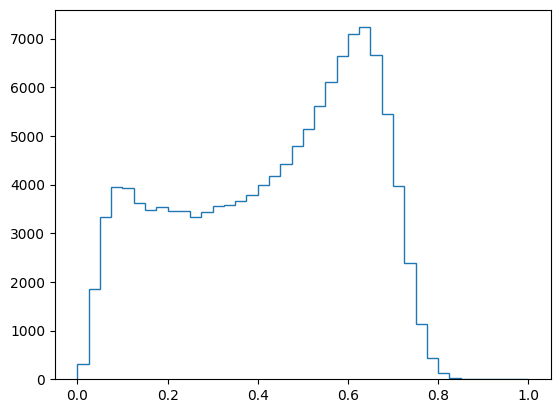

In [8]:
plt.hist(ak.firsts(data_arr.goodjets.GluonBDT), bins=40, histtype='step', label='Data BDT Score', range=(0,1))
# plt.axvline(x=0.65)
plt.show()

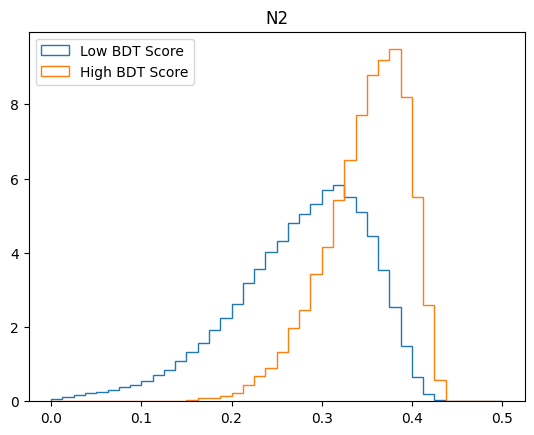

In [23]:
plt.hist(data_arr.goodjets[data_arr.goodjets.GluonBDT[:,0] < 0.6].n2b1[:,0],
         bins=40, label='Low BDT Score', histtype='step', range=(0,.5), density=True)
plt.hist(data_arr.goodjets[data_arr.goodjets.GluonBDT[:,0] >= 0.6].n2b1[:,0],
         bins=40, label='High BDT Score', histtype='step', range=(0,.5), density=True)
plt.legend()
plt.title('N2')
plt.show()

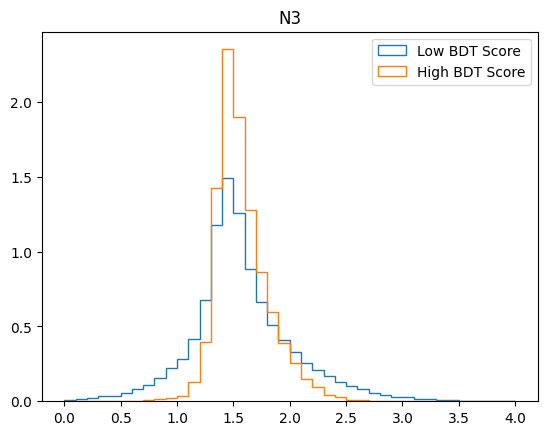

In [30]:
plt.hist(data_arr.goodjets[data_arr.goodjets.GluonBDT[:,0] < 0.65].n3b1[:,0],
         bins=40, label='Low BDT Score', histtype='step', range=(0,4), density=True)
plt.hist(data_arr.goodjets[data_arr.goodjets.GluonBDT[:,0] >= 0.65].n3b1[:,0],
         bins=40, label='High BDT Score', histtype='step', range=(0,4), density=True)
plt.legend()
plt.title('N3')
plt.show()

In [21]:
counts = {}
per = {}
for j in range(0, 100, 5):
    sample_goodjets = data_arr.goodjets[(data_arr.goodjets.GluonBDT >= j/100)]

    mask = ~ak.is_none(ak.firsts(sample_goodjets))
    cut_sample = data_arr[mask]

    counts[str(j/100)] = len(cut_sample)
    per[str(j/100)] = (len(cut_sample) / len(data_arr)) * 100

In [25]:
sample_goodjets = data_arr.goodjets[(data_arr.goodjets.GluonBDT >= 0.65)]

mask = ~ak.is_none(ak.firsts(sample_goodjets))
cut_data = data_arr[mask]

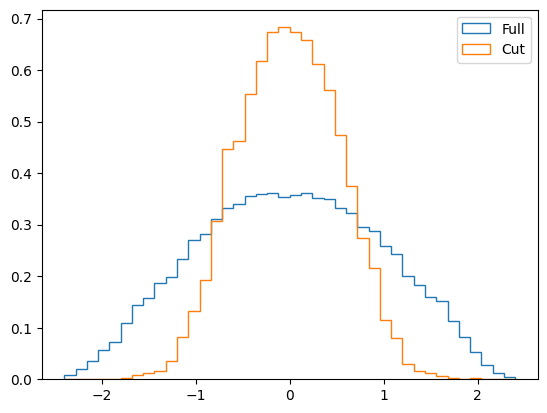

In [29]:
plt.hist(data_arr.goodjets.eta[:,0], bins=40, histtype='step', label='Full', range=(-2.4, 2.4), density=True)
plt.hist(cut_data.goodjets.eta[:,0], bins=40, histtype='step', label='Cut', range=(-2.4,2.4), density=True)
plt.legend()
plt.show()

In [30]:
cut_data

<Array [{event: 619544594, ...}, ..., {...}] type='20204 * {event: uint64, ...'>